In [1]:
%matplotlib inline

import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

def play_sound(x, amp=0.5):

    p = pyaudio.PyAudio()
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)

    # play. May repeat with different volume values (if done interactively) 
    stream.write(amp*x)
    stream.stop_stream()
    stream.close()
    p.terminate()
    pass


def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx


def make_sound(f, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    x = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    return x


def make_AM_sound(f, amp_modulator, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    x = make_sound(f, fs, duration)
    x = np.multiply(x, amp_modulator)
    return x


def make_FM_sound(f, freq_modulator, fs=44100, duration=1.0):
    # generate samples, note conversion to float32 array
    fs = float(fs)
    x = (np.sin(2*np.pi*np.arange(fs*duration)*np.multiply(f/fs, freq_modulator))).astype(np.float32)
    return x


def complex_tone(freqs, amps, duration):
   # make tone
    tones = list()
    for amp, f in zip(amps, freqs):
        tones.append(make_sound(f, fs=fs, duration=duration)*amp)
    tone = np.array(tones).sum(0)  # sum the frequencies together
    return tone


def power_to_db(power, conversion_val=10):
    '''
    This is the conversion from power -> dB, as taken from a stack exchange forum.
    '''
    return conversion_val*np.log10(power)


def db_to_power(db, conversion_val=10):
    '''
    This is the conversion from dB -> power, as also taken from a stack exchange forum.
    '''
    return 10 ** (db/conversion_val)


def get_fft_half(tone, fs):
    power = np.abs(np.fft.fft(tone))
    n = len(power)
    freq = np.fft.fftfreq(n, 1/float(fs))

    # just get first half of spectrum
    half_n = int(np.ceil(n/2.0))
#     power = (2.0 / n) * power[:half_n]
    power = power[:half_n]
    freq_half = freq[:half_n]
    return power, freq_half


def get_db(tone, fs):

    N = 8192  # not sure where this comes from ... :/
    win = np.hamming(N)                                                       
    x = tone[0:N] * win                             # Take a slice and multiply by a window

    sp = np.fft.rfft(x)                               # Calculate real FFT (this just means the first half)

    mag = np.abs(sp) 
    ref = np.sum(win) / 2                             # Reference : window sum and factor of 2
                                                      # because we are using half of FFT spectrum

    s_dbfs = 20 * np.log10(mag / ref)                 # Convert to dBFS
    
    freq = np.fft.fftfreq(N, 1/float(fs))
    half_n = int(np.ceil(N/2.0))  # not sure about N
    freq_half = freq[:half_n+1]
    
    return s_dbfs, freq_half


def plot_wave_and_fft(tone, fs, t_max, freq_max, power_max):
    # plot waveform
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(tone)
    axs[0].set_xlim([0, t_max])
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Amplitude')

    # get fft
    power, freq_half = get_fft_half(tone, fs)

    # plot fft
    axs[1].plot(freq_half, power, lw=4, c='k')
    axs[1].set_xlim([0, freq_max])
    axs[1].set_ylim([0, power_max])
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Power')
    return f


def plot_wave_and_db(tone, fs, t_max, freq_max):
    # plot waveform
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(tone)
    axs[0].set_xlim([0, t_max])
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('Amplitude')

    # get fft
    db, freq_half = get_db(tone, fs)

    # plot fft
    axs[1].plot(freq_half, power_to_db(power), lw=4, c='k')
    axs[1].set_xlim([0, freq_max])
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('dB')
    return f



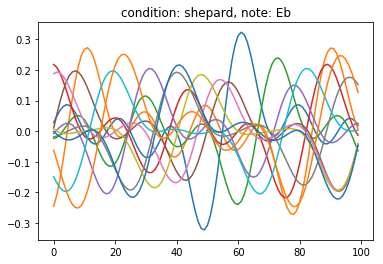

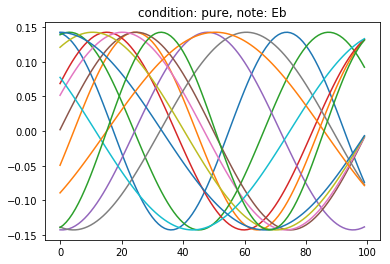

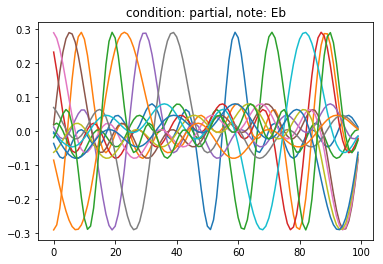

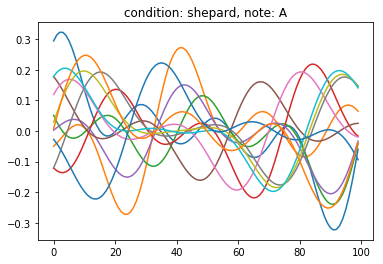

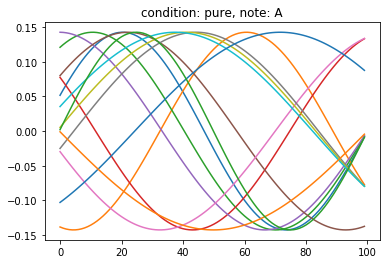

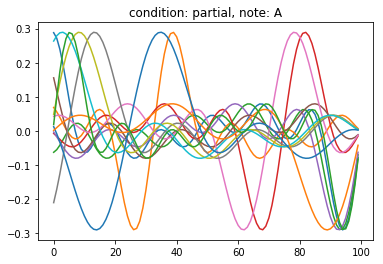

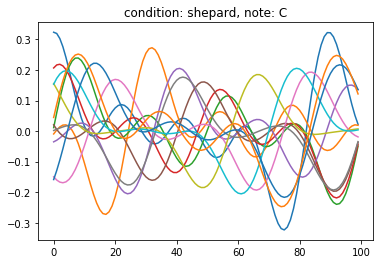

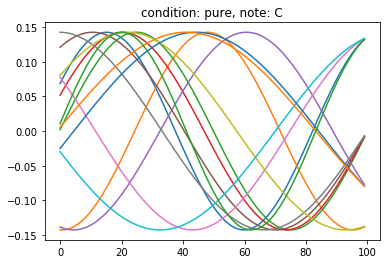

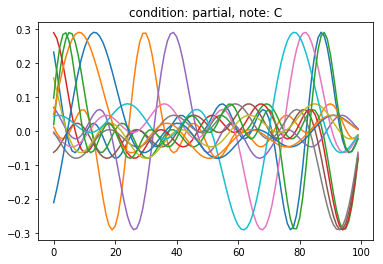

In [19]:
import time
import os

from scipy.io.wavfile import write

# params
fs=44100  # sample freq
duration=0.8
scale_idx = [0, 2, 4, 6, 7, 9, 11]
max_db = -20
min_db = -60
tone_length = 0.3  # desired length in seconds
notes = ['Eb', 'A', 'C']
conditions = ['shepard', 'pure', 'partial']

# semitones for each scale
#d_semitones = np.array([294, 277, 262, 247, 233, 220, 208, 196, 185, 175, 165, 156])
eb_semitones = np.array([312, 330, 349, 370, 392, 415, 440, 466, 494, 523, 554, 587])[::-1]
c_semitones = np.array([494, 466, 440, 415, 392, 370, 349, 330, 311, 294, 277, 262])
a_semitones = np.array([415, 392, 370, 349, 330, 311, 294, 277, 262, 247, 233, 220])

for note in notes:

    for cond in conditions:

        if note == 'Eb':
            semitones = eb_semitones
        elif note == 'C':
            semitones = c_semitones
        elif note == 'A':
            semitones = a_semitones
        
        if cond == 'shepard':
            n_partials = 6
            linear_db = np.linspace(min_db, max_db, len(semitones))[::-1]
            non_linear_amp = np.sqrt(db_to_power(linear_db))
            partial_scaling = non_linear_amp #/ 15
            min_amp = np.min(partial_scaling)
            max_amp = np.max(partial_scaling)

        elif cond == 'pure':
            n_partials = 1
            semitones = np.array(semitones.tolist() + [semitones[-1]*2])
            linear_db = np.ones_like(semitones)
            non_linear_amp = np.sqrt(db_to_power(linear_db))
            partial_scaling = non_linear_amp / 7
            min_amp = np.min(partial_scaling)
            max_amp = np.max(partial_scaling)            

        elif cond == 'partial':
            n_partials = 6
            semitones = np.array(semitones.tolist() + [semitones[-1]*2])
            linear_db = np.ones_like(semitones)
            non_linear_amp = np.sqrt(db_to_power(linear_db))
            partial_scaling = non_linear_amp / 15
            min_amp = np.min(partial_scaling)
            max_amp = np.max(partial_scaling)       
            
        # bin for tones
        tones = list()
        scale_tones = list()

        # loop through each note of the a scale
        for ii, f0 in enumerate(semitones):
            # start the timer
            t0 = time.time()

            # get the freqs
            freqs = [f0*p for p in range(1, n_partials+1)]
            if cond == 'partial':  # remove f0 for partial
                freqs = freqs[1:]
            # scale the odd partials by scalar
            attenuation_1_3 = partial_scaling[ii]  # this is the intermediary value (neither min nor max -- somewhere on the linear line)
            attenuation_6 = partial_scaling[::-1][ii]  # this is the intermediary value for the last partial

            amps = list()
            for jj in range(1, n_partials+1):  # loop through partial numbers (1 - 6, not 0-5)

                # if it is partial 5 -- stay at the min
                if jj == 5:
                    amps.append(min_amp)  # stays low constantly

                # if it is partial 6 -- give attenuation up
                elif jj == 6:
                    amps.append(attenuation_6) # scales in the opposite direction of 1&3     

                # if it is partial 2 or 4 -- keep at max
                elif jj == 2 or jj == 4:
                    amps.append(max_amp)  # if it's even, do not mess with the amp (it stays the same throughout)

               # if it is partial 1 or 3 -- give attenuation down
                elif jj == 1 or jj == 3:
                    amps.append(attenuation_1_3)  # if it's odd, attenuate.

                else:
                    raise ValueError('You screwed up somewhere.')

            # make tone
            tone = complex_tone(freqs, amps, duration)
            tones.append(tone[0:int(fs*tone_length)])

#             plt.plot(tone[0:100])
            plt.plot(tone[-100:])

        plt.title('condition: %s, note: %s' % (cond, note))
        plt.show()
    

__Now, let's make some Shepard tones!!__

587
587


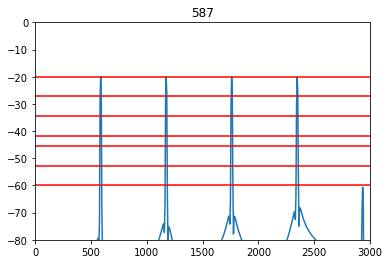

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_587-min-60_max-20.wav
554
554
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_554-min-60_max-20.wav
523
523


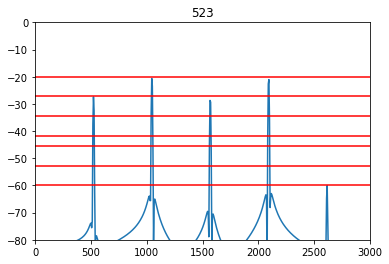

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_523-min-60_max-20.wav
494
494
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_494-min-60_max-20.wav
466
466


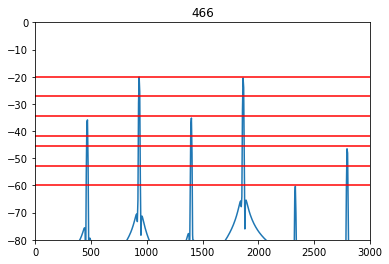

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_466-min-60_max-20.wav
440
440
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_440-min-60_max-20.wav
415
415


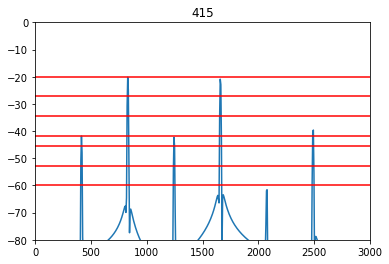

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_415-min-60_max-20.wav
392
392


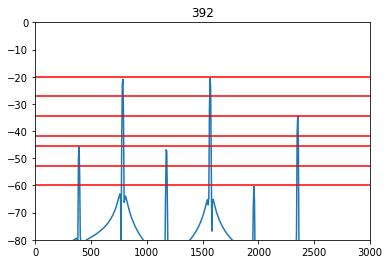

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_392-min-60_max-20.wav
370
370
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_370-min-60_max-20.wav
349
349


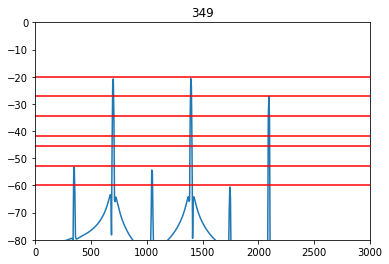

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_349-min-60_max-20.wav
330
330
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_330-min-60_max-20.wav
312
312


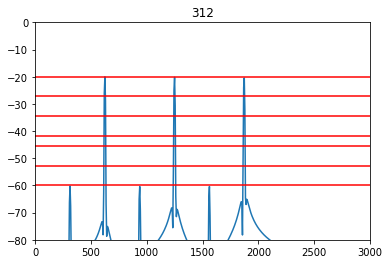

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-Eb_312-min-60_max-20.wav
587
587


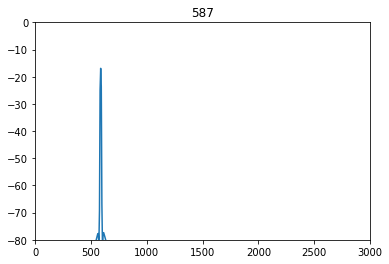

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_587-min-60_max-20.wav
554
554
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_554-min-60_max-20.wav
523
523


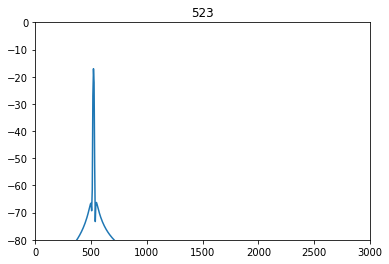

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_523-min-60_max-20.wav
494
494
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_494-min-60_max-20.wav
466
466


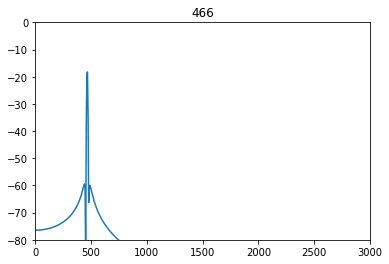

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_466-min-60_max-20.wav
440
440
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_440-min-60_max-20.wav
415
415


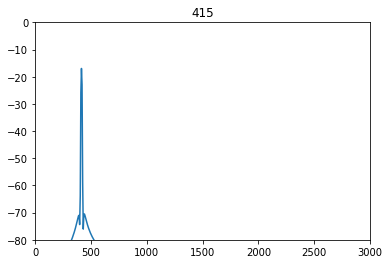

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_415-min-60_max-20.wav
392
392


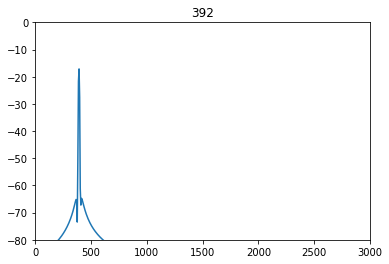

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_392-min-60_max-20.wav
370
370
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_370-min-60_max-20.wav
349
349


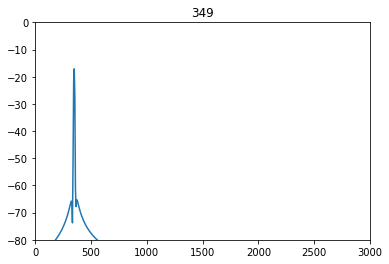

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_349-min-60_max-20.wav
330
330
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_330-min-60_max-20.wav
312
312


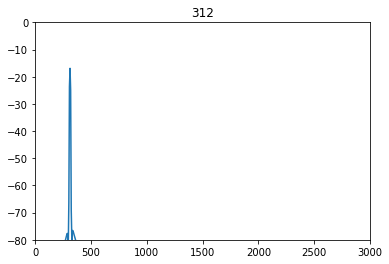

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_312-min-60_max-20.wav
624
624
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-Eb_624-min-60_max-20.wav
587
587


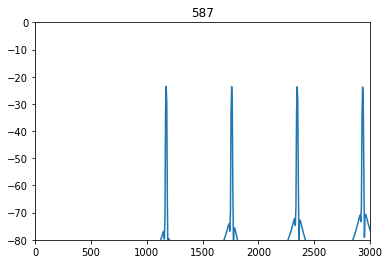

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_587-min-60_max-20.wav
554
554
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_554-min-60_max-20.wav
523
523


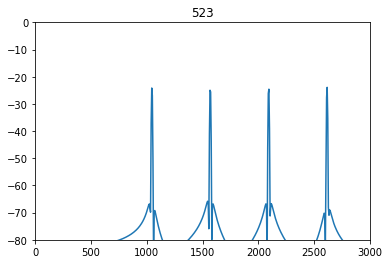

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_523-min-60_max-20.wav
494
494
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_494-min-60_max-20.wav
466
466


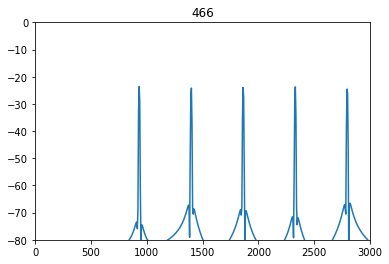

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_466-min-60_max-20.wav
440
440
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_440-min-60_max-20.wav
415
415


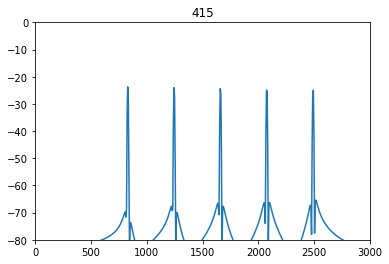

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_415-min-60_max-20.wav
392
392


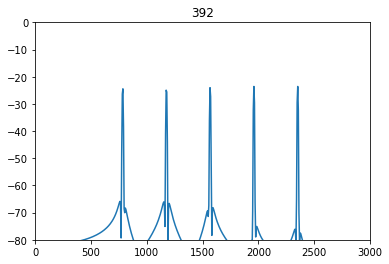

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_392-min-60_max-20.wav
370
370
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_370-min-60_max-20.wav
349
349


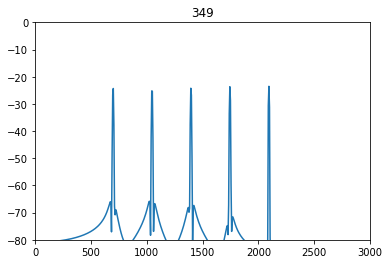

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_349-min-60_max-20.wav
330
330
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_330-min-60_max-20.wav
312
312


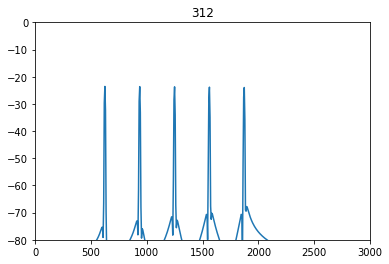

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_312-min-60_max-20.wav
624
624
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-Eb_624-min-60_max-20.wav
415
415


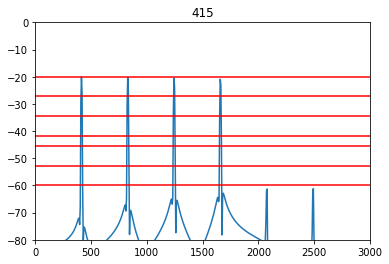

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_415-min-60_max-20.wav
392
392
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_392-min-60_max-20.wav
370
370


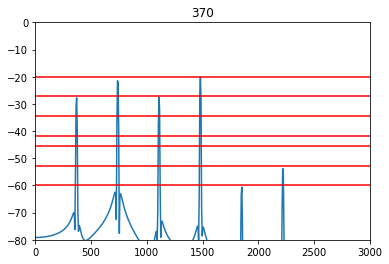

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_370-min-60_max-20.wav
349
349
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_349-min-60_max-20.wav
330
330


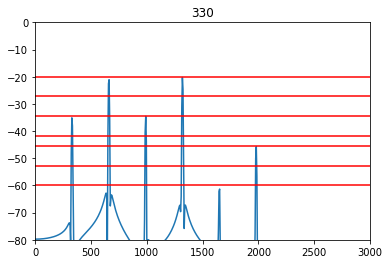

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_330-min-60_max-20.wav
311
311
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_311-min-60_max-20.wav
294
294


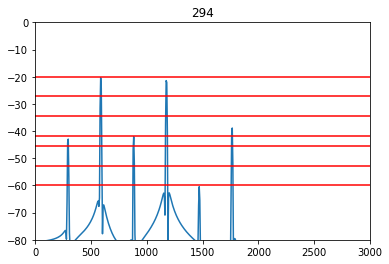

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_294-min-60_max-20.wav
277
277


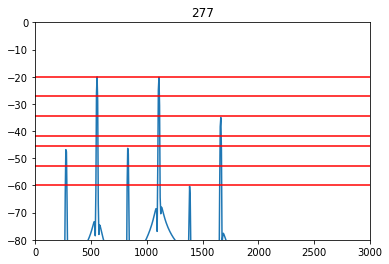

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_277-min-60_max-20.wav
262
262
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_262-min-60_max-20.wav
247
247


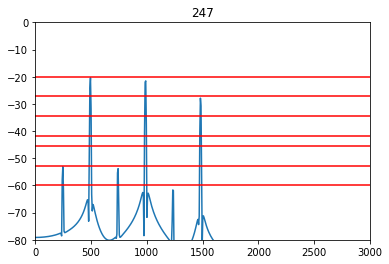

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_247-min-60_max-20.wav
233
233
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_233-min-60_max-20.wav
220
220


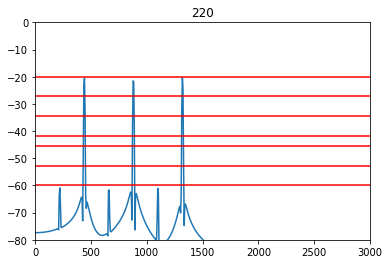

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-A_220-min-60_max-20.wav
415
415


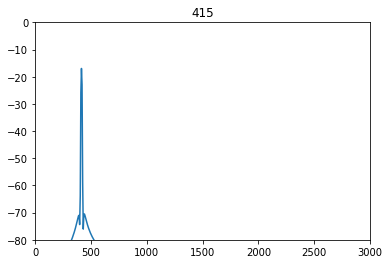

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_415-min-60_max-20.wav
392
392
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_392-min-60_max-20.wav
370
370


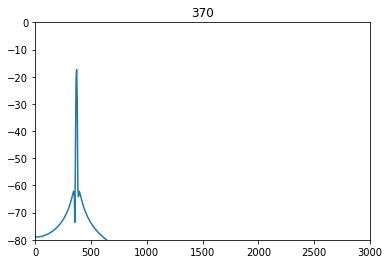

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_370-min-60_max-20.wav
349
349
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_349-min-60_max-20.wav
330
330


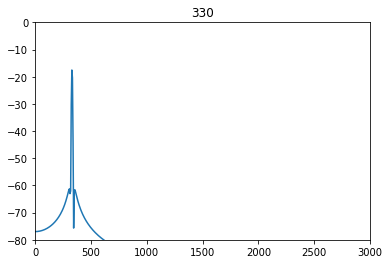

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_330-min-60_max-20.wav
311
311
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_311-min-60_max-20.wav
294
294


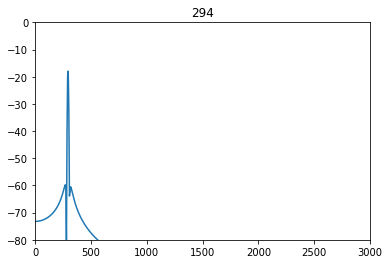

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_294-min-60_max-20.wav
277
277


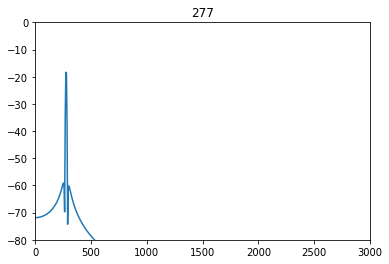

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_277-min-60_max-20.wav
262
262
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_262-min-60_max-20.wav
247
247


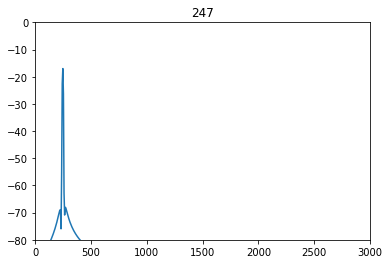

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_247-min-60_max-20.wav
233
233
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_233-min-60_max-20.wav
220
220


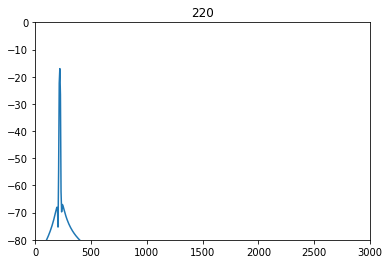

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_220-min-60_max-20.wav
440
440
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-A_440-min-60_max-20.wav
415
415


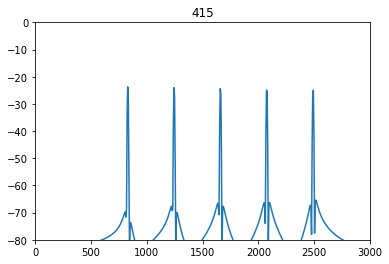

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_415-min-60_max-20.wav
392
392
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_392-min-60_max-20.wav
370
370


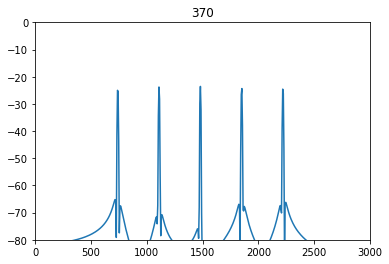

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_370-min-60_max-20.wav
349
349
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_349-min-60_max-20.wav
330
330


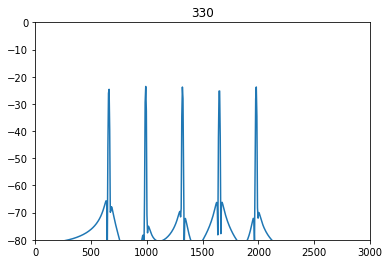

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_330-min-60_max-20.wav
311
311
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_311-min-60_max-20.wav
294
294


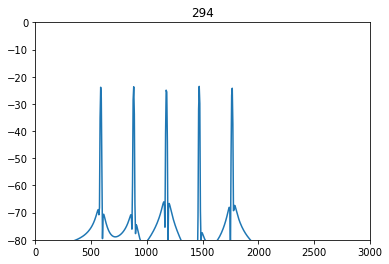

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_294-min-60_max-20.wav
277
277


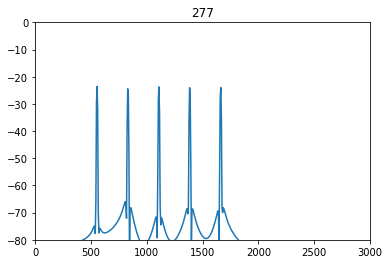

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_277-min-60_max-20.wav
262
262
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_262-min-60_max-20.wav
247
247


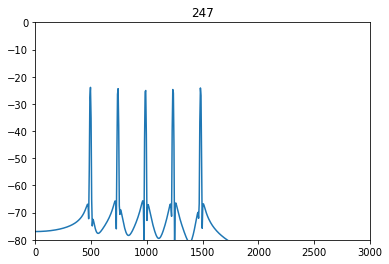

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_247-min-60_max-20.wav
233
233
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_233-min-60_max-20.wav
220
220


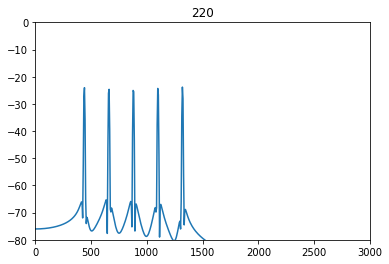

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_220-min-60_max-20.wav
440
440
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-A_440-min-60_max-20.wav
494
494


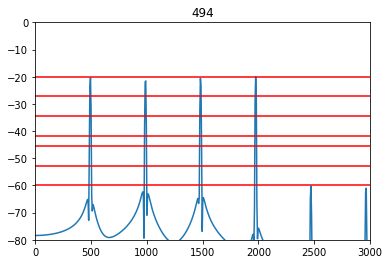

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_494-min-60_max-20.wav
466
466
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_466-min-60_max-20.wav
440
440


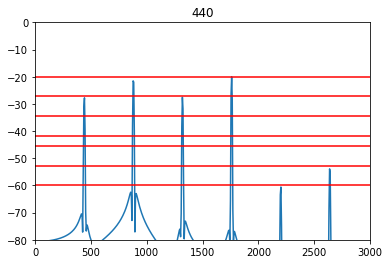

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_440-min-60_max-20.wav
415
415
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_415-min-60_max-20.wav
392
392


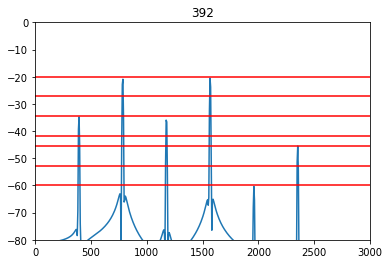

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_392-min-60_max-20.wav
370
370
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_370-min-60_max-20.wav
349
349


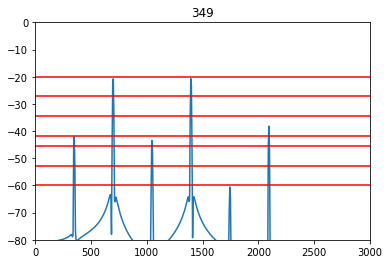

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_349-min-60_max-20.wav
330
330


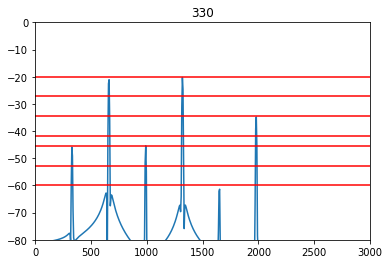

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_330-min-60_max-20.wav
311
311
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_311-min-60_max-20.wav
294
294


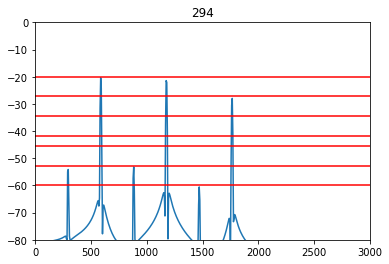

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_294-min-60_max-20.wav
277
277
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_277-min-60_max-20.wav
262
262


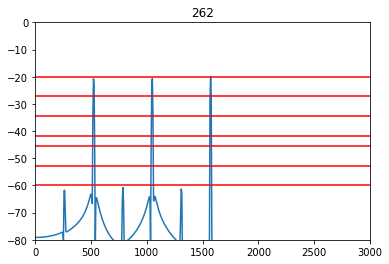

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/shepard-C_262-min-60_max-20.wav
494
494


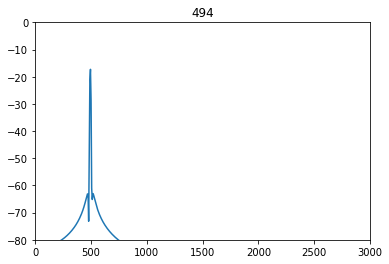

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_494-min-60_max-20.wav
466
466
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_466-min-60_max-20.wav
440
440


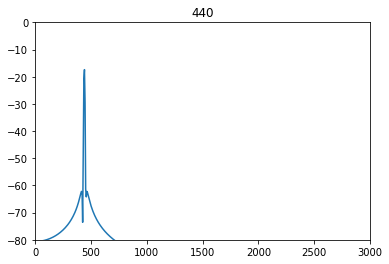

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_440-min-60_max-20.wav
415
415
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_415-min-60_max-20.wav
392
392


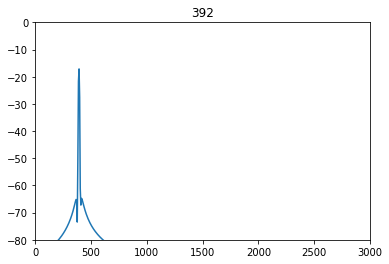

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_392-min-60_max-20.wav
370
370
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_370-min-60_max-20.wav
349
349


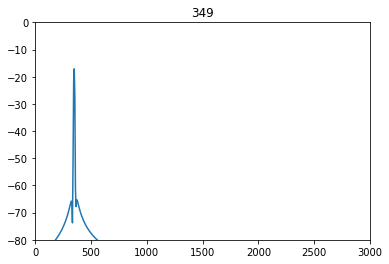

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_349-min-60_max-20.wav
330
330


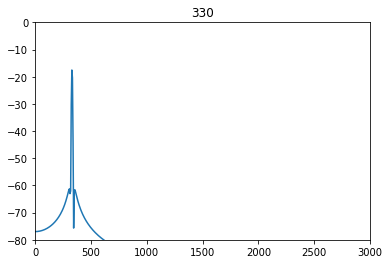

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_330-min-60_max-20.wav
311
311
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_311-min-60_max-20.wav
294
294


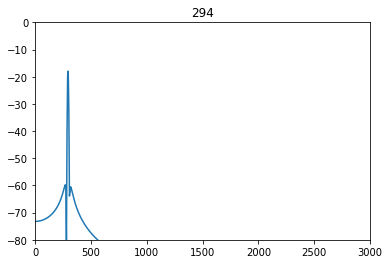

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_294-min-60_max-20.wav
277
277
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_277-min-60_max-20.wav
262
262


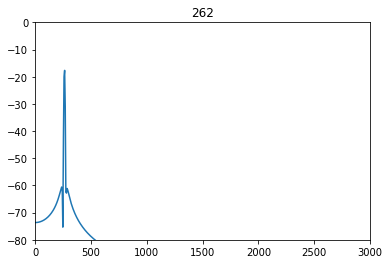

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_262-min-60_max-20.wav
524
524
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/pure-C_524-min-60_max-20.wav
494
494


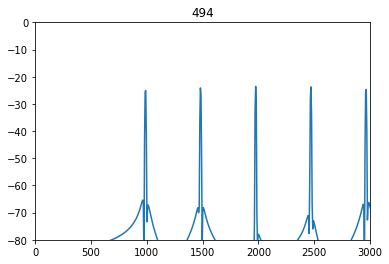

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_494-min-60_max-20.wav
466
466
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_466-min-60_max-20.wav
440
440


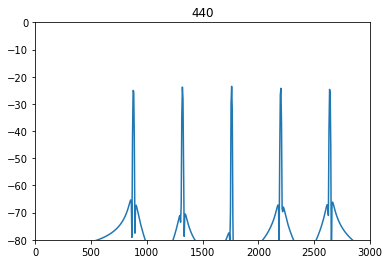

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_440-min-60_max-20.wav
415
415
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_415-min-60_max-20.wav
392
392


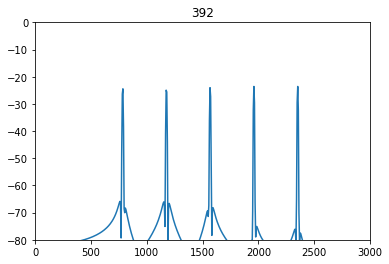

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_392-min-60_max-20.wav
370
370
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_370-min-60_max-20.wav
349
349


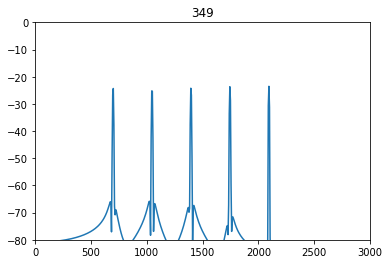

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_349-min-60_max-20.wav
330
330


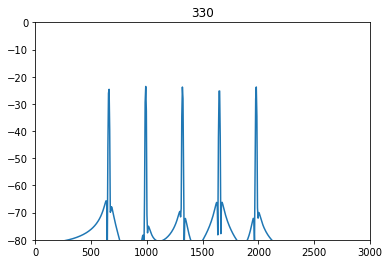

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_330-min-60_max-20.wav
311
311
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_311-min-60_max-20.wav
294
294


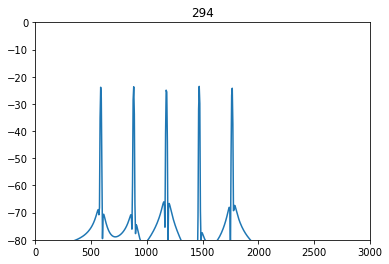

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_294-min-60_max-20.wav
277
277
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_277-min-60_max-20.wav
262
262


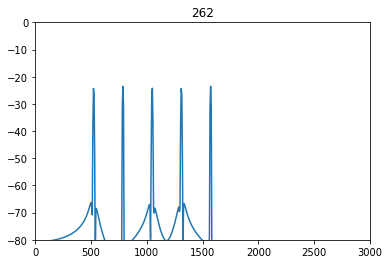

/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_262-min-60_max-20.wav
524
524
/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth/tmp_max-20_min-60/partial-C_524-min-60_max-20.wav


In [2]:
import time
import os

from scipy.io.wavfile import write
base_dir = '/Users/ellieabrams/Desktop/Projects/Shepard/shepard/tones_dbsmooth'

# params
fs=44100  # sample freq
duration=0.8
scale_idx = [0, 2, 4, 6, 7, 9, 11]
max_db = -20
min_db = -60
tone_length = 0.3  # desired length in seconds
notes = ['Eb', 'A', 'C']
conditions = ['shepard', 'pure', 'partial']

# semitones for each scale
#d_semitones = np.array([294, 277, 262, 247, 233, 220, 208, 196, 185, 175, 165, 156])
eb_semitones = np.array([312, 330, 349, 370, 392, 415, 440, 466, 494, 523, 554, 587])[::-1]
c_semitones = np.array([494, 466, 440, 415, 392, 370, 349, 330, 311, 294, 277, 262])
a_semitones = np.array([415, 392, 370, 349, 330, 311, 294, 277, 262, 247, 233, 220])

# make temporary folder
save_dir = '%s/tmp_max%s_min%s' % (base_dir, max_db, min_db)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    silence = np.zeros(int(fs*0.2))
    fname = '%s/silence.wav' % (save_dir)
    write(fname, fs, silence)

for note in notes:

    for cond in conditions:

        if note == 'Eb':
            semitones = eb_semitones
        elif note == 'C':
            semitones = c_semitones
        elif note == 'A':
            semitones = a_semitones
        
        if cond == 'shepard':
            n_partials = 6
            linear_db = np.linspace(min_db, max_db, len(semitones))[::-1]
            non_linear_amp = np.sqrt(db_to_power(linear_db))
            partial_scaling = non_linear_amp #/ 15
            min_amp = np.min(partial_scaling)
            max_amp = np.max(partial_scaling)

        elif cond == 'pure':
            n_partials = 1
            semitones = np.array(semitones.tolist() + [semitones[-1]*2])
            linear_db = np.ones_like(semitones)
            non_linear_amp = np.sqrt(db_to_power(linear_db))
            partial_scaling = non_linear_amp / 7
            min_amp = np.min(partial_scaling)
            max_amp = np.max(partial_scaling)            

        elif cond == 'partial':
            n_partials = 6
            semitones = np.array(semitones.tolist() + [semitones[-1]*2])
            linear_db = np.ones_like(semitones)
            non_linear_amp = np.sqrt(db_to_power(linear_db))
            partial_scaling = non_linear_amp / 15
            min_amp = np.min(partial_scaling)
            max_amp = np.max(partial_scaling)       
            
        # bin for tones
        tones = list()
        scale_tones = list()

        # loop through each note of the a scale
        for ii, f0 in enumerate(semitones):
            print f0
            # start the timer
            t0 = time.time()

            # get the freqs
            freqs = [f0*p for p in range(1, n_partials+1)]
            if cond == 'partial':  # remove f0 for partial
                freqs = freqs[1:]
            print f0
            # scale the odd partials by scalar
            attenuation_1_3 = partial_scaling[ii]  # this is the intermediary value (neither min nor max -- somewhere on the linear line)
            attenuation_6 = partial_scaling[::-1][ii]  # this is the intermediary value for the last partial

            amps = list()
            for jj in range(1, n_partials+1):  # loop through partial numbers (1 - 6, not 0-5)

                # if it is partial 5 -- stay at the min
                if jj == 5:
                    amps.append(min_amp)  # stays low constantly

                # if it is partial 6 -- give attenuation up
                elif jj == 6:
                    amps.append(attenuation_6) # scales in the opposite direction of 1&3     

                # if it is partial 2 or 4 -- keep at max
                elif jj == 2 or jj == 4:
                    amps.append(max_amp)  # if it's even, do not mess with the amp (it stays the same throughout)

               # if it is partial 1 or 3 -- give attenuation down
                elif jj == 1 or jj == 3:
                    amps.append(attenuation_1_3)  # if it's odd, attenuate.

                else:
                    raise ValueError('You screwed up somewhere.')

            # make tone
            tone = complex_tone(freqs, amps, duration)
            tones.append(tone[0:int(fs*tone_length)])

            if ii in scale_idx:
#                 # listen        
#                 play_sound(tone)
                scale_tones.append(tone[0:int(fs*tone_length)])

                dbs, freq_half = get_db(tone, fs)
                plt.plot(freq_half, dbs)
                for lin_db in linear_db[scale_idx]:
                    plt.axhline(lin_db, c='r')
                plt.xlim([0, 3000])
                plt.ylim([-80, 0])
                plt.title(f0)
                plt.show()

            fname = '%s/%s-%s_%s-min%s_max%s.wav' % (save_dir, cond, note, f0, min_db, max_db)
            write(fname, fs, tone[0:int(fs*tone_length)])
            print(fname)
            
        # save the entire sequence to file
        n_reps = 5
        fname = '%s/%s-%s-%s-min%s_max%s-up.wav' % (save_dir, note, cond, f0, min_db, max_db)
        write(fname, fs, np.concatenate(tones*n_reps))
        fname = '%s/%s-%s-%s-min%s_max%s-down.wav' % (save_dir, note, cond, f0, min_db, max_db)
        write(fname, fs, np.concatenate(tones*n_reps)[::-1])

        fname = '%s/%s-%s-%s-min%s_max%s-up_scale.wav' % (save_dir, note, cond, f0, min_db, max_db)
        write(fname, fs, np.concatenate(scale_tones*n_reps))
        fname = '%s/%s-%s-%s-min%s_max%s-down_scale.wav' % (save_dir, note, cond, f0, min_db, max_db)
        write(fname, fs, np.concatenate(scale_tones*n_reps)[::-1])


In [5]:
expected_trial_n = (12 * 3) + (13 * 3) + (13 * 3)
print('we should have %s files total.' % (expected_trial_n))

we should have 114 files total.
